## 13	MODELADO DE SERIES DE TIEMPO FINANCIERAS

## 13.1	Descomposición de series de tiempo

In [ ]:
# 1. Importar las librerías

!pip install quandl

import pandas as pd
import quandl
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
import warnings


In [ ]:
# 2. Descargue los precios del oro para 2000-2011 y vuelva a muestrear a valores mensuales:


QUANDL_KEY = 'api key'# reemplace api key con su propia clave de la API  
quandl.ApiConfig.api_key = QUANDL_KEY

df = quandl.get(dataset='WGC/GOLD_MONAVG_USD',
                start_date='2000-01-01', 
                end_date='2011-12-31')

df.rename(columns={'Value': 'price'}, inplace=True)
df = df.resample('M').last()

print(f'Shape of DataFrame: {df.shape}')
df.head()




Shape of DataFrame: (144, 1)


price
Date              
2000-01-31  284.31
2000-02-29  299.86
2000-03-31  286.39
2000-04-30  279.69
2000-05-31  275.19

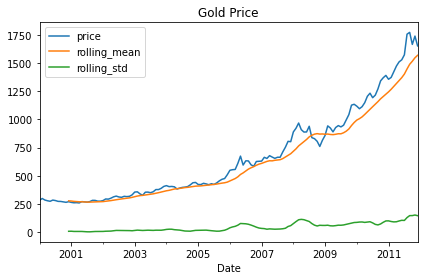

In [ ]:
# 3. Agregue la media móvil y la desviación estándar:

WINDOW_SIZE = 12
df['rolling_mean'] = df.price.rolling(window=WINDOW_SIZE).mean()
df['rolling_std'] = df.price.rolling(window=WINDOW_SIZE).std()
df.plot(title='Gold Price')

plt.tight_layout()
#plt.savefig('images/ch3_im1.png')
plt.show()


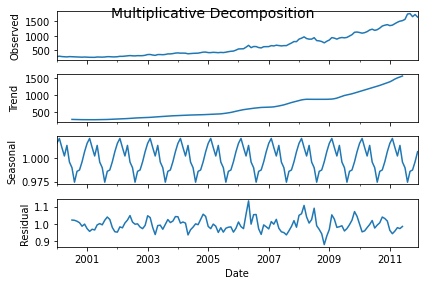

In [ ]:
# 4. Realice la descomposición estacional mediante el modelo multiplicativo:

decomposition_results = seasonal_decompose(df.price, 
                                           model='multiplicative')
decomposition_results.plot() \
                     .suptitle('Multiplicative Decomposition', 
                               fontsize=14)

plt.tight_layout()
# plt.savefig('images/ch3_im2.png')
plt.show()


## 13.2	Descomposición de series de tiempo usando Prophet de Facebook

In [ ]:
# 1. Importe las librerías y autentíquese con Quandl:

import pandas as pd
import seaborn as sns
import quandl
from fbprophet import Prophet

QUANDL_KEY = '2x6hdWS5mY11Jn1YUdLE' # reemplace {key} con su propia clave 
quandl.ApiConfig.api_key = QUANDL_KEY


In [ ]:
# 2. Descargue los precios diarios del oro y cambie el nombre de las columnas:

df = quandl.get(dataset='WGC/GOLD_DAILY_USD',
                start_date='2000-01-01',
                end_date='2005-12-31')

df.reset_index(drop=False, inplace=True)
df.rename(columns={'Date': 'ds', 'Value': 'y'}, inplace=True)


In [ ]:
# 3. Divida la serie en conjuntos de entrenamiento y prueba:

train_indices = df.ds.apply(lambda x: x.year).values < 2005
df_train = df.loc[train_indices].dropna()
df_test = df.loc[~train_indices].reset_index(drop=True)


In [ ]:
# 4. Cree la instancia del modelo y ajústela a los datos:

model_prophet = Prophet(seasonality_mode='additive')
model_prophet.add_seasonality(name='monthly', period=30.5, fourier_order=5)
model_prophet.fit(df_train)


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


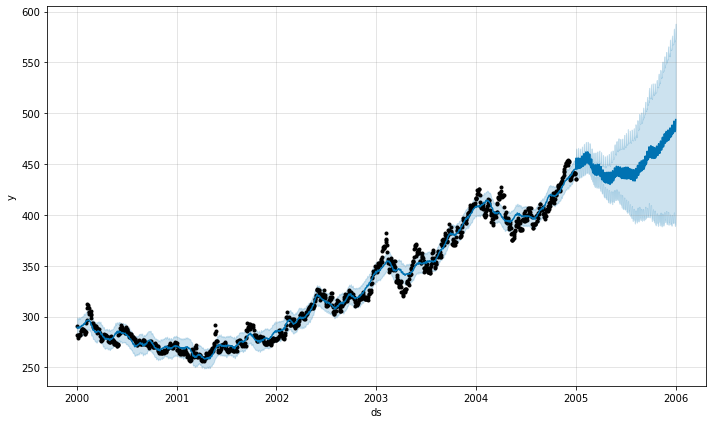

In [ ]:
# 5. Pronostique los precios del oro con 1 año de anticipación y trace los resultados:

df_future = model_prophet.make_future_dataframe(periods=365)
df_pred = model_prophet.predict(df_future)
model_prophet.plot(df_pred)

plt.tight_layout()
#plt.savefig('images/ch3_im3.png')
plt.show()


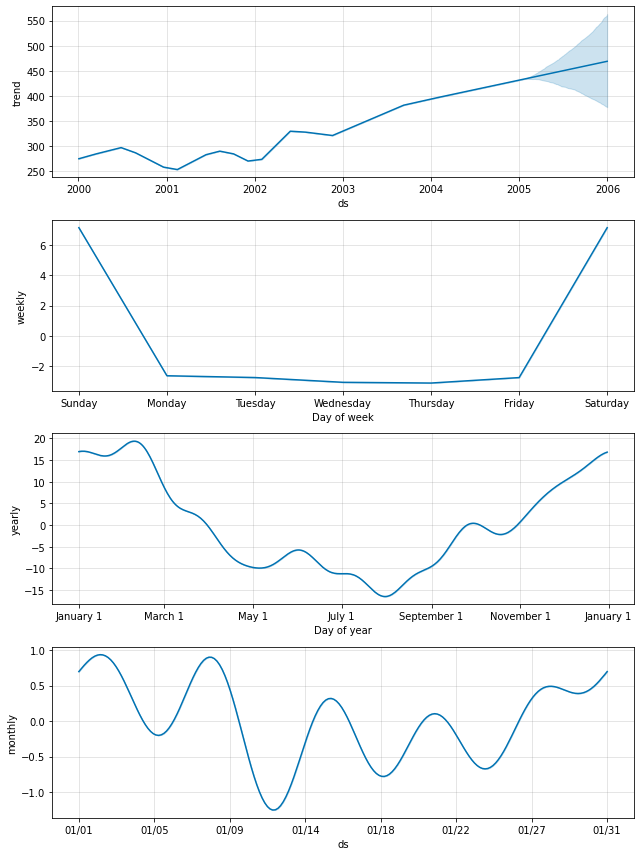

In [ ]:
# 6. Inspeccione la descomposición de la serie temporal:

model_prophet.plot_components(df_pred)

plt.tight_layout()
#plt.savefig('images/ch3_im4.png')
plt.show()


In [ ]:
# 1. Fusionar el conjunto de prueba con las previsiones:

selected_columns = ['ds', 'yhat_lower', 'yhat_upper', 'yhat']

df_pred = df_pred.loc[:, selected_columns].reset_index(drop=True)
df_test = df_test.merge(df_pred, on=['ds'], how='left')
df_test.ds = pd.to_datetime(df_test.ds)
df_test.set_index('ds', inplace=True)



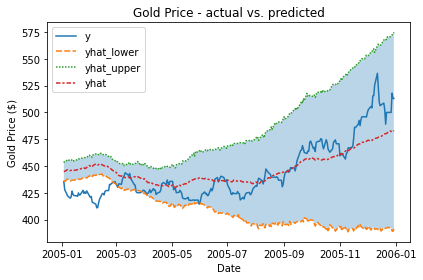

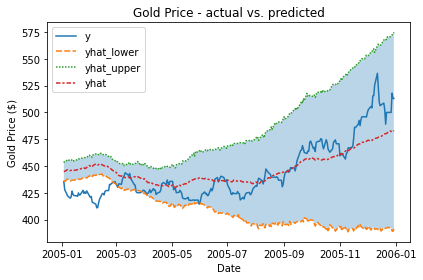

In [ ]:
fig, ax = plt.subplots(1, 1)

ax = sns.lineplot(data=df_test[['y', 'yhat_lower', 
                                'yhat_upper', 'yhat']])
ax.fill_between(df_test.index,
                df_test.yhat_lower,
                df_test.yhat_upper,
                alpha=0.3)
ax.set(title='Gold Price - actual vs. predicted',
       xlabel='Date',
       ylabel='Gold Price ($)')

plt.tight_layout()
#plt.savefig('images/ch3_im5.png')
plt.show()


fig, ax = plt.subplots(1, 1)

ax = sns.lineplot(data=df_test[['y', 'yhat_lower', 
                                'yhat_upper', 'yhat']])
ax.fill_between(df_test.index,
                df_test.yhat_lower,
                df_test.yhat_upper,
                alpha=0.3)
ax.set(title='Gold Price - actual vs. predicted',
       xlabel='Date',
       ylabel='Gold Price ($)')

plt.tight_layout()
#plt.savefig('images/ch3_im5.png')
plt.show()


## 13.3	Prueba de estacionariedad en series de tiempo

In [ ]:
# 1. Importar las librerías

import pandas as pd
import quandl
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, kpss


In [ ]:
# 2. Descargar los datos

QUANDL_KEY = '2x6hdWS5mY11Jn1YUdLE' # reemplace {key} con su clave  
quandl.ApiConfig.api_key = QUANDL_KEY

df = quandl.get(dataset='WGC/GOLD_MONAVG_USD',
                start_date='2000-01-01', 
                end_date='2011-12-31')

df.rename(columns={'Value': 'price'}, inplace=True)
df = df.resample('M').last()



In [ ]:
# 3. Defina una función para ejecutar la prueba ADF

def adf_test(x):
    '''
    Función para realizar la prueba de estacionariedad de Dickey-Fuller aumentada
    
    Hipótesis nula: La serie de tiempo no es estacionaria
    Hipótesis alternativa: La serie de tiempo es estacionaria

    Parámetros
    ----------
    x : pd.Series / np.array
     La serie de tiempo que se comprobará para determinar la estacionariedad.
    
    Returns
    -------
    results: pd.DataFrame
        A DataFrame with the ADF test's results
    '''
    
    indices = ['Test Statistic', 'p-value',
               '# of Lags Used', '# of Observations Used']
    
    adf_test = adfuller(x, autolag='AIC')
    results = pd.Series(adf_test[0:4], index=indices)
    
    for key, value in adf_test[4].items():
        results[f'Critical Value ({key})'] = value

    return results

adf_test(df.price)





Test Statistic              3.510499
p-value                     1.000000
# of Lags Used             14.000000
# of Observations Used    129.000000
Critical Value (1%)        -3.482088
Critical Value (5%)        -2.884219
Critical Value (10%)       -2.578864
dtype: float64

In [ ]:
#4. Definimos una función para ejecutar la prueba KPSS

def kpss_test(x, h0_type='c'):
    '''
    Función para realizar la prueba de estacionariedad Kwiatkowski-Phillips-Schmidt-Shin 

    Hipótesis nula: La serie de tiempo es estacionaria
    Hipótesis alternativa: La serie de tiempo no es estacionaria

    Parámetros
    ----------
    x: pd.Series / np.array
        The time series to be checked for stationarity
    h0_type: str{'c', 'ct'}
        Indicates the null hypothesis of the KPSS test:
            * 'c': The data is stationary around a constant(default)
            * 'ct': The data is stationary around a trend
    
    Returns
    -------
    results: pd.DataFrame
        A DataFrame with the KPSS test's results
    '''
    
    indices = ['Test Statistic', 'p-value', '# of Lags']

    kpss_test = kpss(x, regression=h0_type)
    results = pd.Series(kpss_test[0:3], index=indices)
    
    for key, value in kpss_test[3].items():
        results[f'Critical Value ({key})'] = value

    return results

kpss_test(df.price)


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1685: FutureWarning:

The behavior of using lags=None will change in the next release. Currently lags=None is the same as lags='legacy', and so a sample-size lag length is used. After the next release, the default will change to be the same as lags='auto' which uses an automatic lag length selection method. To silence this warning, either use 'auto' or 'legacy'

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1709: InterpolationWarning:

p-value is smaller than the indicated p-value



Test Statistic            0.985671
p-value                   0.010000
# of Lags                14.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64

In [ ]:
# 5. Genere las gráficas ACF / PACF:

N_LAGS = 40
SIGNIFICANCE_LEVEL = 0.05

fig, ax = plt.subplots(2, 1)
plot_acf(df.price, ax=ax[0], lags=N_LAGS, 
         alpha=SIGNIFICANCE_LEVEL)
plot_pacf(df.price, ax=ax[1], lags=N_LAGS, 
          alpha=SIGNIFICANCE_LEVEL)

plt.tight_layout()
#plt.savefig('images/ch3_im8.png')
plt.show()


## 13.4	Corrección de la estacionariedad en series de tiempo

In [ ]:

# 1. Importar librerías y actualizer datos de inflación

!pip install cpi

import pandas as pd
import quandl
import cpi
import numpy as np
from datetime import date
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, kpss


# update the CPI data (if needed)
# cpi.update()




In [ ]:
# 2. Descargar los datos:

QUANDL_KEY = '2x6hdWS5mY11Jn1YUdLE' # reemplace {key} con su clave  
quandl.ApiConfig.api_key = QUANDL_KEY

df = quandl.get(dataset='WGC/GOLD_MONAVG_USD',
                start_date='2000-01-01', 
                end_date='2011-12-31')

df.rename(columns={'Value': 'price'}, inplace=True)
df = df.resample('M').last()


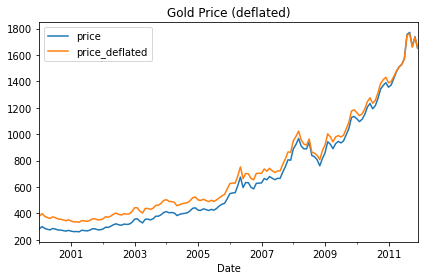

In [ ]:
# 3. Deflacte los precios del oro (a los valores de 2011-12-31 USD) y grafique los resultados:

DEFL_DATE = date(2011, 12, 31)

df['dt_index'] = df.index.map(lambda x: x.to_pydatetime().date())
df['price_deflated'] = df.apply(lambda x: cpi.inflate(x.price,
                                                      x.dt_index, 
                                                      DEFL_DATE), 
                                axis=1)
df[['price', 'price_deflated']].plot(title='Gold Price (deflated)')

plt.tight_layout()
#plt.savefig('images/ch3_im9.png')
plt.show()


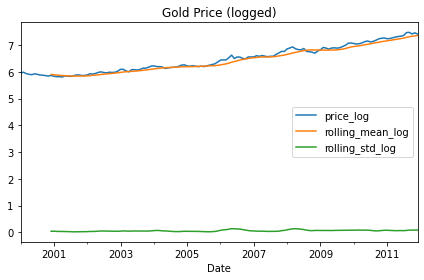

In [ ]:
# 4. Deflactar la serie usando un logaritmo natural y graficando con las métricas continuas

WINDOW = 12
selected_columns = ['price_log', 'rolling_mean_log', 
                    'rolling_std_log']

df['price_log'] = np.log(df.price_deflated)
df['rolling_mean_log'] = df.price_log.rolling(WINDOW) \
                           .mean()
df['rolling_std_log'] = df.price_log.rolling(WINDOW) \
                          .std()

df[selected_columns].plot(title='Gold Price (logged)')

plt.tight_layout()
#plt.savefig('images/ch3_im10.png')
plt.show()


In [ ]:
# 6. Diferenciación de la serie

selected_columns = ['price_log_diff', 'roll_mean_log_diff', 
                    'roll_std_log_diff']

df['price_log_diff'] = df.price_log.diff(1)
df['roll_mean_log_diff'] = df.price_log_diff.rolling(WINDOW) \
                             .mean()
df['roll_std_log_diff'] = df.price_log_diff.rolling(WINDOW) \
                            .std()
df[selected_columns].plot(title='Gold Price (1st differences)')

plt.tight_layout()
#plt.savefig('images/ch3_im12.png')
plt.show()


## 13.5	Modelado de series de tiempo con métodos de suavizado exponencial

In [ ]:
# 1. Definir lista de colores

import seaborn as sns 

plt.set_cmap('cubehelix')
sns.set_palette('cubehelix')

COLORS = [plt.cm.cubehelix(x) for x in [0.1, 0.3, 0.5, 0.7]]


<Figure size 432x288 with 0 Axes>

In [ ]:
# 2. Importar las librería

!pip install yfinance

import pandas as pd
import numpy as np
import yfinance as yf
from datetime import date
from statsmodels.tsa.holtwinters import (ExponentialSmoothing, 
                                         SimpleExpSmoothing, 
                                         Holt)


In [ ]:
# 3. Descargar los precios ajustados de las acciones de Google:

df = yf.download('GOOG',
                 start='2010-01-01',
                 end='2018-12-31',
                 adjusted=True,
                 progress=False)

print(f'Downloaded {df.shape[0]} rows of data.')


Downloaded 2263 rows of data.


In [ ]:
# 4. Agregado a la frecuencia mensual:

goog = df.resample('M') \
         .last() \
         .rename(columns={'Adj Close': 'adj_close'}) \
         .adj_close


In [ ]:
# 5. Se crea la división de entrenamiento / prueba:

train_indices = goog.index.year < 2018
goog_train = goog[train_indices]
goog_test = goog[~train_indices]

test_length = len(goog_test)


In [ ]:
# 6. Se grafican los precios:

goog.plot(title="Google's Stock Price")

plt.tight_layout()
#plt.savefig('images/ch3_im14.png')
plt.show()


In [ ]:
# 7. Se ajustan tres modelos SES y se crean pronósticos para ellos:

ses_1 = SimpleExpSmoothing(goog_train).fit(smoothing_level=0.2)
ses_forecast_1 = ses_1.forecast(test_length)

ses_2 = SimpleExpSmoothing(goog_train).fit(smoothing_level=0.5)
ses_forecast_2 = ses_2.forecast(test_length)

ses_3 = SimpleExpSmoothing(goog_train).fit()
alpha = ses_3.model.params['smoothing_level']
ses_forecast_3 = ses_3.forecast(test_length)


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning:

After 0.13 initialization must be handled at model creation



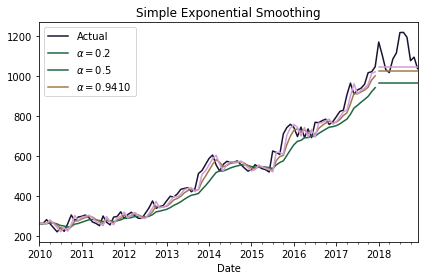

In [ ]:
# 8. Se grafican los precios originales y los resultados de los modelos

goog.plot(color=COLORS[0], 
          title='Simple Exponential Smoothing',
          label='Actual',
          legend=True)

ses_forecast_1.plot(color=COLORS[1], legend=True, 
                    label=r'$\alpha=0.2$')
ses_1.fittedvalues.plot(color=COLORS[1])

ses_forecast_2.plot(color=COLORS[2], legend=True, 
                    label=r'$\alpha=0.5$')
ses_2.fittedvalues.plot(color=COLORS[2])

ses_forecast_3.plot(color=COLORS[3], legend=True, 
                    label=r'$\alpha={0:.4f}$'.format(alpha))
ses_3.fittedvalues.plot(color=COLORS[3])

plt.tight_layout()
#plt.savefig('images/ch3_im15.png')
plt.show()


In [ ]:
# 9. Se ajustan tres variantes del modelo de suavizado de Holt y se crean pronósticos

# Modelo de Holt con tendencia lineal
hs_1 = Holt(goog_train).fit()
hs_forecast_1 = hs_1.forecast(test_length)

# Modelo de Holt con tendencia exponencial
hs_2 = Holt(goog_train, exponential=True).fit()
# equivalent to ExponentialSmoothing(goog_train, trend='mul').fit()
hs_forecast_2 = hs_2.forecast(test_length)

# Modelo de Holt con tendencia exponencial y atenuación
hs_3 = Holt(goog_train, exponential=False, 
            damped=True).fit(damping_slope=0.99)
hs_forecast_3 = hs_3.forecast(test_length)


In [ ]:
# 10. Se trazan los precios originales y los resultados de los modelos:

goog.plot(color=COLORS[0],
          title="Holt's Smoothing models",
          label='Actual',
          legend=True)

hs_1.fittedvalues.plot(color=COLORS[1])
hs_forecast_1.plot(color=COLORS[1], legend=True, 
                   label='Linear trend')

hs_2.fittedvalues.plot(color=COLORS[2])
hs_forecast_2.plot(color=COLORS[2], legend=True, 
                   label='Exponential trend')

hs_3.fittedvalues.plot(color=COLORS[3])
hs_forecast_3.plot(color=COLORS[3], legend=True, 
                   label='Exponential trend (damped)')

plt.tight_layout()
#plt.savefig('images/ch3_im16.png')
plt.show()


In [ ]:
SEASONAL_PERIODS = 12

# Modelo de Holt-Winter con tendencia exponencial
hw_1 = ExponentialSmoothing(goog_train, 
                            trend='mul', 
                            seasonal='add', 
                            seasonal_periods=SEASONAL_PERIODS).fit()
hw_forecast_1 = hw_1.forecast(test_length)

# Modelo de Holt-Winter con tendencia exponencial y atenuación
hw_2 = ExponentialSmoothing(goog_train, 
                            trend='mul', 
                            seasonal='add', 
                            seasonal_periods=SEASONAL_PERIODS, 
                            damped=True).fit()
hw_forecast_2 = hw_2.forecast(test_length)



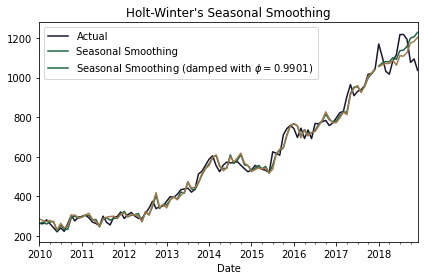

In [ ]:
goog.plot(color=COLORS[0],
          title="Holt-Winter's Seasonal Smoothing",
          label='Actual',
          legend=True)

hw_1.fittedvalues.plot(color=COLORS[1])
hw_forecast_1.plot(color=COLORS[1], legend=True, 
                   label='Seasonal Smoothing')

phi = hw_2.model.params['damping_trend']
plot_label = f'Seasonal Smoothing (damped with $\phi={phi:.4f}$)'

hw_2.fittedvalues.plot(color=COLORS[2])
hw_forecast_2.plot(color=COLORS[2], legend=True, 
                   label=plot_label)

plt.tight_layout()
#plt.savefig('images/ch3_im17.png')
plt.show()



## 13.6	Modelado de series de tiempo con modelos de clase ARIMA

In [ ]:
# 1. Importar librerías

import yfinance as yf
import pandas as pd
import numpy as np
from statsmodels.tsa.arima_model import ARIMA
#import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.stats.diagnostic import acorr_ljungbox
import scipy.stats as scs




In [ ]:
# 2. Descargue los precios de las acciones de Google y vuelva a muestrear con frecuencia semanal:

df = yf.download('GOOG',
                 start='2015-01-01',
                 end='2018-12-31',
                 adjusted=True,
                 progress=False)

goog = df.resample('W') \
         .last() \
         .rename(columns={'Adj Close': 'adj_close'}) \
         .adj_close


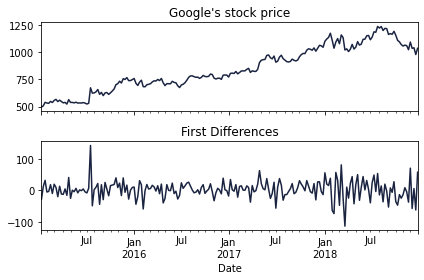

In [ ]:
# 3. Aplique las primeras diferencias a la serie de precios y grafíquelas juntas

goog_diff = goog.diff().dropna()

fig, ax = plt.subplots(2, sharex=True)
goog.plot(title = "Google's stock price", ax=ax[0])
goog_diff.plot(ax=ax[1], title='First Differences')

plt.tight_layout()
#plt.savefig('images/ch3_im18.png')
plt.show()


In [ ]:
# 5. Con base en los resultados de las pruebas, se especifica el modelo ARIMA y se ajusta a los datos

arima = ARIMA(goog, order=(2, 1, 1)).fit(disp=0)
arima.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:            D.adj_close   No. Observations:                  208
Model:                 ARIMA(2, 1, 1)   Log Likelihood                -987.233
Method:                       css-mle   S.D. of innovations             27.859
Date:                Thu, 08 Jul 2021   AIC                           1984.466
Time:                        14:42:33   BIC                           2001.154
Sample:                    01-11-2015   HQIC                          1991.214
                         - 12-30-2018                                         
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 2.4700      1.441      1.714      0.088      -0.354       5.294
ar.L1.D.adj_close    -0.3908      0.280     -1.398      0.164      -0.939       0.157
ar.L2.D.adj_close    -0.1910      0.082     -2.322      0.021      -0.352      -0.030
ma.L1.D.adj_close     0.1780      0.280      0.637      0.525      -0.370       0.726
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.0232           -2.0467j            2.2883           -0.3238
AR.2           -1.0232           +2.0467j            2.2883            0.3238
MA.1           -5.6165           +0.0000j            5.6165            0.5000
-----------------------------------------------------------------------------
"""

In [ ]:
# 6. Preparamos una función para diagnosticar el ajuste del modelo en función de sus residuos

def arima_diagnostics(resids, n_lags=40):
    '''
    Función para diagnosticar el ajuste de un modelo ARIMA 
investigando los residuos.
    
    Parametros
    ----------
    resids : np.array
        An array containing the residuals of a fitted model
    n_lags : int
        Number of lags for autocorrelation plot
        
    Returns
    -------
    fig : matplotlib.figure.Figure
        Created figure
    '''
     
    # Crear subtramas
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)

    r = resids
    resids = (r - np.nanmean(r)) / np.nanstd(r)
    resids_nonmissing = resids[~(np.isnan(resids))]


    # Residuales sobre el tiempo
    sns.lineplot(x=np.arange(len(resids)), y=resids, ax=ax1)
    ax1.set_title('Standardized residuals')

    # Distribución de residuales
    x_lim = (-1.96 * 2, 1.96 * 2)
    r_range = np.linspace(x_lim[0], x_lim[1])
    norm_pdf = scs.norm.pdf(r_range)
    
    sns.distplot(resids_nonmissing, hist=True, kde=True, 
                 norm_hist=True, ax=ax2)
    ax2.plot(r_range, norm_pdf, 'g', lw=2, label='N(0,1)')
    ax2.set_title('Distribution of standardized residuals')
    ax2.set_xlim(x_lim)
    ax2.legend()
        
    # Gráfico Q-Q 
    qq = sm.qqplot(resids_nonmissing, line='s', ax=ax3)
    ax3.set_title('Q-Q plot')

    # Gráfico ACF 
    plot_acf(resids, ax=ax4, lags=n_lags, alpha=0.05)
    ax4.set_title('ACF plot')

    return fig

    
      


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



NameError: ignored

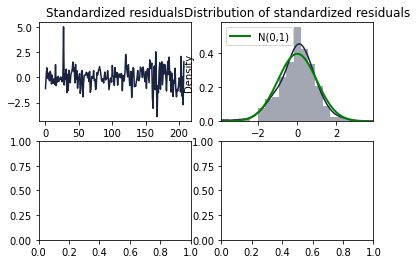

In [ ]:
arima_diagnostics(arima.resid, 40)

plt.tight_layout()
#plt.savefig('images/ch3_im21.png')
plt.show()


In [ ]:
# 8. Aplicamos la prueba de Ljung-Box para no autocorrelación en los residuos y graficamos los resultados

ljung_box_results = acorr_ljungbox(arima.resid)

fig, ax = plt.subplots(1, figsize=[16, 5])
sns.scatterplot(x=range(len(ljung_box_results[1])), 
                y=ljung_box_results[1], 
                ax=ax)
ax.axhline(0.05, ls='--', c='r')
ax.set(title="Ljung-Box test's results",
       xlabel='Lag',
       ylabel='p-value')

plt.tight_layout()
#plt.savefig('images/ch3_im22.png')
plt.show()


/usr/local/lib/python3.7/dist-packages/statsmodels/stats/diagnostic.py:533: FutureWarning:

The default value of lags is changing.  After 0.12, this value will become min(10, nobs//5). Directly setlags to silence this warning.

/usr/local/lib/python3.7/dist-packages/statsmodels/stats/diagnostic.py:559: FutureWarning:

The value returned will change to a single DataFrame after 0.12 is released.  Set return_df to True to use to return a DataFrame now.  Set return_df to False to silence this warning.

